# Notebook for evaluating aggregation of rankings with different metrics

In [1]:
import pandas as pd
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from rankers.Ranker import Ranker
from sklearn.ensemble import AdaBoostClassifier
from Evaluations import mapk, mrr, get_preds_and_actual, get_pr_curve, get_evaluation_plots
from matplotlib import pyplot as plt

## Getting train and test data in correct format

In [2]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1


In [3]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [4]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [5]:
train_y

0           1.0
1           1.0
2           0.0
3           0.0
4           0.0
           ... 
11557589    0.0
11557590    0.0
11557591    0.0
11557592    0.0
11557593    0.0
Name: purchased, Length: 11557594, dtype: float64

## Doing Ranking

### Fitting Rankers

In [6]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [7]:
adaboost_ranker = Ranker(AdaBoostClassifier())

In [8]:
lgbm_ranker = lgbm_ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.844955
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.151118
[LightGBM] [Debug] init for col-wise cost 0.228547 seconds, init for row-wise cost 0.735539 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.578193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 11557594, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10


In [9]:
for i in lgbm_ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], lgbm_ranker.feature_importances_[i]/lgbm_ranker.feature_importances_.sum())

bestseller_rank 0.999066481760161
article_id 0.00028298358632459234
age 0.0002444961714550688
garment_group_no 7.157281908016381e-05
club_member_status 6.724645263245181e-05
postal_code 6.510081422729875e-05
product_type_no 6.100419025057176e-05
colour_group_code 5.175429599815084e-05
department_no 3.6910397657910145e-05
Active 2.4511482560733915e-05
graphical_appearance_no 1.4670190618276406e-05
perceived_colour_value_id 1.3267839033840464e-05
fashion_news_frequency 0.0
FN 0.0
section_no 0.0
index_code 0.0
perceived_colour_master_id 0.0
index_group_no 0.0


In [10]:
adaboost_ranker = adaboost_ranker.fit(
    train_X,
    train_y,
)

In [11]:
for i in adaboost_ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], adaboost_ranker.feature_importances_[i]/adaboost_ranker.feature_importances_.sum())

article_id 0.38
product_type_no 0.18
garment_group_no 0.12
bestseller_rank 0.08
colour_group_code 0.06
department_no 0.04
perceived_colour_value_id 0.04
club_member_status 0.02
fashion_news_frequency 0.02
postal_code 0.02
perceived_colour_master_id 0.02
age 0.02
Active 0.0
FN 0.0
section_no 0.0
index_code 0.0
graphical_appearance_no 0.0
index_group_no 0.0


### Making Predictions

In [12]:
test['lgbm_preds'] = lgbm_ranker.predict(test_X)

In [13]:
test['adaboost_preds'] = adaboost_ranker.predict(test_X)

In [14]:
#for combining: rank predictions, sum the rankings
test['sum_preds'] = (test['lgbm_preds'].rank() + test['adaboost_preds'].rank())

In [15]:
#for combining: rank predictions, multiply the rankings
test['prod_preds'] = (test['lgbm_preds'].rank() * test['adaboost_preds'].rank())

### Combining rankings by interleaving

In [16]:
#interleaving: combine rankings A and B by reordering as: A[0], B[0], A[1], B[1], A[2], etc
#if the next item from B was already included from A (and vice versa), ignore, and get the next item from A
lgbm = test[['article_id', 'customer_id', 'lgbm_preds']].copy().sort_values(by=['customer_id', 'lgbm_preds'], ascending=False).reset_index()
ada = test[['article_id', 'customer_id', 'adaboost_preds']].copy().sort_values(by=['customer_id', 'adaboost_preds'], ascending=False).reset_index()

interleaved = pd.concat([ada[['article_id', 'customer_id']], lgbm[['article_id', 'customer_id']]]).sort_index().reset_index(drop=True)

In [17]:
#dataframe of predictions, grouped by customer, and ranked by strength of prediction
#(first article most likely)
ada.head(20)

,index,article_id,customer_id,adaboost_preds
0,18215787,875784002,18446705133201055310,-0.683264
1,18215790,918522001,18446705133201055310,-0.746115
2,18215798,673677002,18446705133201055310,-0.748084
3,18215795,918292001,18446705133201055310,-0.748653
4,18215791,924243001,18446705133201055310,-0.748870
5,18215794,809238001,18446705133201055310,-0.749387
6,18215797,809238005,18446705133201055310,-0.749387
7,18215793,751471001,18446705133201055310,-0.749753
8,18215792,448509014,18446705133201055310,-0.750362
9,18215788,909370001,18446705133201055310,-0.751691


In [18]:
lgbm.head(20)

,index,article_id,customer_id,lgbm_preds
0,18215787,875784002,18446705133201055310,0.177601
1,18215790,918522001,18446705133201055310,-0.183540
2,18215795,918292001,18446705133201055310,-0.190491
3,18215788,909370001,18446705133201055310,-0.190624
4,18215789,865799006,18446705133201055310,-0.191753
5,18215792,448509014,18446705133201055310,-0.191753
6,18215793,751471001,18446705133201055310,-0.191753
7,18215794,809238001,18446705133201055310,-0.195148
8,18215797,809238005,18446705133201055310,-0.195148
9,18215798,673677002,18446705133201055310,-0.195148


In [19]:
#potential transactions, grouped by customer, ranked by interleaving adaboost ranker
#predictions and lgbm ranker predictions
interleaved.head(30)

,article_id,customer_id
0,875784002,18446705133201055310
1,875784002,18446705133201055310
2,918522001,18446705133201055310
3,918522001,18446705133201055310
4,673677002,18446705133201055310
5,918292001,18446705133201055310
6,918292001,18446705133201055310
7,909370001,18446705133201055310
8,924243001,18446705133201055310
9,865799006,18446705133201055310


In [20]:
#length of interleaved frame is 2x length of predictions from either of the 2
#constituent ranking lists (50% of entries are repeats as LGBM and adaboost rankings)
#are produced from same candidates.
print(len(interleaved.index))
print(len(ada.index))
print(len(lgbm.index))

13316412
6658206
6658206


In [21]:
#dropping repeated customer_id, article_id pairs and keeping first instance
interleaved = interleaved.drop_duplicates(subset=['customer_id', 'article_id'], keep='first')\
                .reset_index()

In [22]:
len(interleaved.index)

6658206

In [23]:
interleaved.head(20)

,index,article_id,customer_id
0,0,875784002,18446705133201055310
1,2,918522001,18446705133201055310
2,4,673677002,18446705133201055310
3,5,918292001,18446705133201055310
4,7,909370001,18446705133201055310
5,8,924243001,18446705133201055310
6,9,865799006,18446705133201055310
7,10,809238001,18446705133201055310
8,11,448509014,18446705133201055310
9,12,809238005,18446705133201055310


In [24]:
#applying rankings within the group so first prediciton has highest number
interleaved['interleaved_preds'] = interleaved.groupby('customer_id')['index'].rank(method="dense", ascending=False)

In [25]:
interleaved.head(30)

,index,article_id,customer_id,interleaved_preds
0,0,875784002,18446705133201055310,13.0
1,2,918522001,18446705133201055310,12.0
2,4,673677002,18446705133201055310,11.0
3,5,918292001,18446705133201055310,10.0
4,7,909370001,18446705133201055310,9.0
5,8,924243001,18446705133201055310,8.0
6,9,865799006,18446705133201055310,7.0
7,10,809238001,18446705133201055310,6.0
8,11,448509014,18446705133201055310,5.0
9,12,809238005,18446705133201055310,4.0


In [26]:
test = pd.merge(test, interleaved[['customer_id', 'article_id', 'interleaved_preds']], on=['customer_id', 'article_id'], how='left')

In [27]:
#sanity check - no predictions from interleaved method are nan
test['interleaved_preds'].isna().sum()

0

In [28]:
#all rankings present in dataframe
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,Active,club_member_status,fashion_news_frequency,age,postal_code,lgbm_preds,adaboost_preds,sum_preds,prod_preds,interleaved_preds
0,2020-09-03,28847241659200,925246001,0.128797,2,104,0.0,999.0,925246,25454,...,1,0,1,21,57896,0.183500,-0.681900,13149590.0,4.322786e+13,13.0
1,2020-07-14,28847241659200,909370001,0.032947,1,104,0.0,1.0,909370,23319,...,1,0,1,21,57896,-0.185850,-0.750750,6303940.0,5.919616e+12,12.0
2,2020-07-14,28847241659200,865799006,0.033340,1,104,0.0,2.0,865799,18468,...,1,0,1,21,57896,-0.191753,-0.753279,3432550.5,4.524063e+11,8.0
3,2020-07-14,28847241659200,918522001,0.041416,1,104,0.0,3.0,918522,26372,...,1,0,1,21,57896,-0.188774,-0.745178,9664200.0,2.334796e+13,11.0
4,2020-07-14,28847241659200,924243001,0.041549,1,104,0.0,4.0,924243,19190,...,1,0,1,21,57896,-0.198444,-0.747931,3538028.5,7.289887e+11,7.0


In [29]:
pred_cols = ['lgbm_preds', 'adaboost_preds', 'sum_preds', 'prod_preds', 'interleaved_preds']

# Evaluating Predictions

In [30]:
'''
mapk_per_col = {}
mapk_per_col_dense = {}
mrr_per_col = []
mrr_per_col_dense = []
pr_curves_dense = {}

for pred_method in pred_cols:
    print(f"Evaluation for {pred_method}\n####################\n")
    #Getting predictions and actual purchases in same format
    preds, actual_purchases, preds_dense, actual_purchases_dense = get_preds_and_actual(test, pred_method, test_week_transactions, pd.read_csv('../../../Data/sample_submission.csv'), bestsellers_previous_week)

    mapk_per_col[pred_method] = [mapk(actual_purchases, preds, k=i) for i in range(1,12)]
    
    mapk_per_col_dense[pred_method] = [mapk(actual_purchases_dense, preds_dense, k=i) for i in range(1,12)]

    pr_curves_dense[pred_method] = get_pr_curve(actual_purchases_dense, preds_dense, 12)


    #MAPK of data at k=12 (competition requirements)
    print(f"MAP@12 (all customers):             {mapk_per_col[pred_method][-1]}")
    print(f"MAP@12 (only purchasing customers): {mapk_per_col_dense[pred_method][-1]}\n")

    mrr_per_col.append(mrr(actual_purchases, preds))
    mrr_per_col_dense.append(mrr(actual_purchases_dense, preds_dense))

    print(f"MRR (all customers):                {mrr_per_col[-1]}")
    print(f"MRR (only purchasing customers):    {mrr_per_col_dense[-1]}\n\n\n")
'''

Evaluation for lgbm_preds
####################

MAP@12 (all customers):             0.001157985612232424
MAP@12 (only purchasing customers): 0.02303045779123624

MRR (all customers):                0.002188700583921364
MRR (only purchasing customers):    0.043529708731422256



Evaluation for adaboost_preds
####################

MAP@12 (all customers):             0.0011576697562486603
MAP@12 (only purchasing customers): 0.02302417592743298

MRR (all customers):                0.002193330272274571
MRR (only purchasing customers):    0.0436217857322751



Evaluation for sum_preds
####################

MAP@12 (all customers):             0.0011641704622810647
MAP@12 (only purchasing customers): 0.023153464438715878

MRR (all customers):                0.0022094180008471755
MRR (only purchasing customers):    0.04394174459008332



Evaluation for prod_preds
####################

MAP@12 (all customers):             0.0011584476914787006
MAP@12 (only purchasing customers): 0.023039647798836

In [ ]:
mapk_per_col, mapk_per_col_dense, mrr_per_col, mrr_per_col_dense, pr_curves_dense = get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

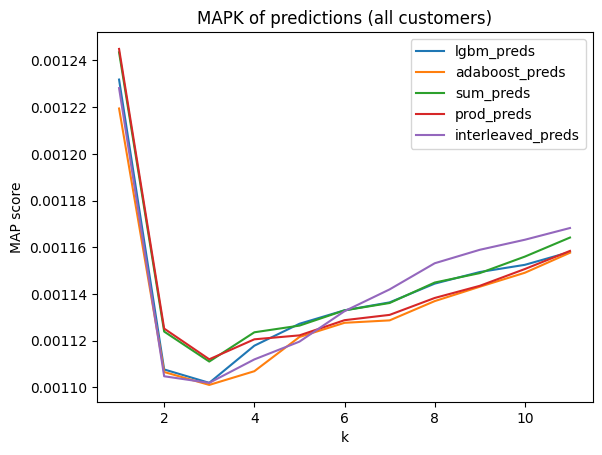

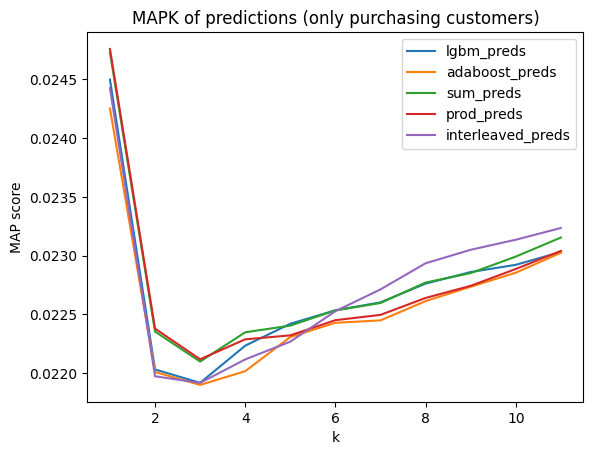

In [31]:
#visualising MAPK scores
plt.figure()
for method, scores in mapk_per_col.items():
    plt.plot(range(1,12), scores, label=method)
plt.ylabel("MAP score")
plt.xlabel("k")
plt.title(f"MAPK of predictions (all customers)")
plt.legend()
plt.show()

plt.figure()
for method, scores in mapk_per_col_dense.items():
    plt.plot(range(1,12), scores, label=method)
plt.ylabel("MAP score")
plt.xlabel("k")
plt.title(f"MAPK of predictions (only purchasing customers)")
plt.legend()
plt.show()

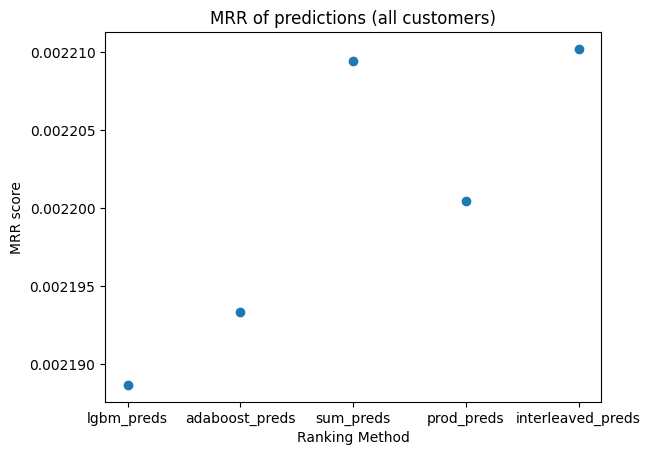

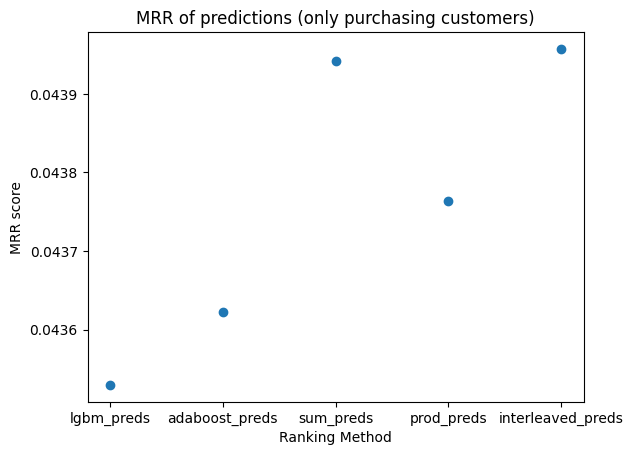

In [32]:
plt.figure()
plt.scatter(pred_cols, mrr_per_col)
plt.ylabel("MRR score")
plt.xlabel("Ranking Method")
plt.title(f"MRR of predictions (all customers)")
plt.show()

plt.figure()
plt.scatter(pred_cols, mrr_per_col_dense)
plt.ylabel("MRR score")
plt.xlabel("Ranking Method")
plt.title(f"MRR of predictions (only purchasing customers)")
plt.show()


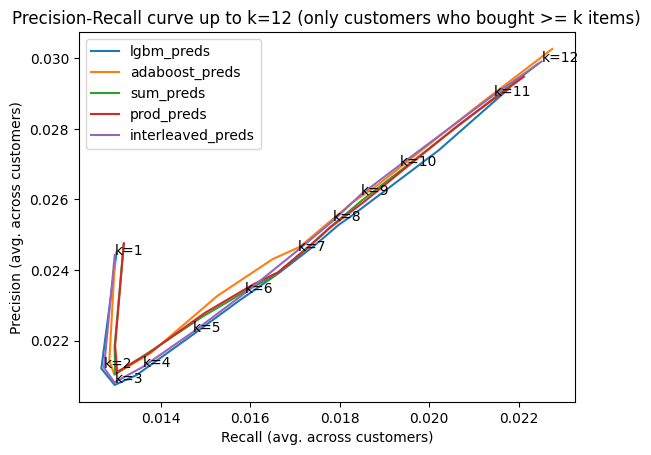

In [33]:
plt.figure()
for method, scores in pr_curves_dense.items():
    plt.plot(scores[1], scores[0], label=method)

for i in range(len(scores[0])):
    plt.annotate(f"k={i+1}", xy=(scores[1][i], scores[0][i]))
plt.ylabel("Precision (avg. across customers)")
plt.xlabel("Recall (avg. across customers)")
plt.title(f"Precision-Recall curve up to k=12 (only customers who bought >= k items)")
plt.legend()
plt.show()

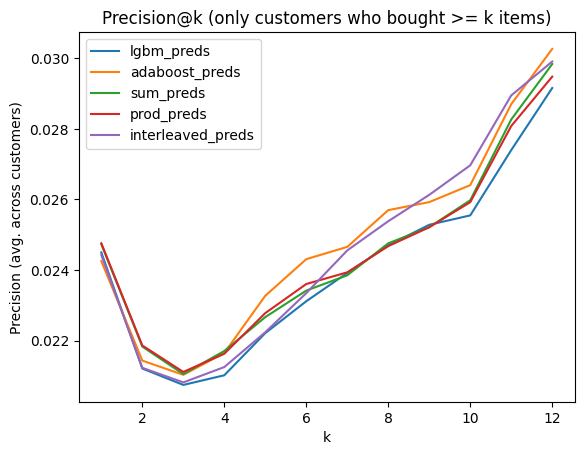

In [34]:
plt.figure()
for method, scores in pr_curves_dense.items():
    plt.plot(range(1, len(scores[0])+1), scores[0], label=method)
plt.ylabel("Precision (avg. across customers)")
plt.xlabel("k")
plt.title(f"Precision@k (only customers who bought >= k items)")
plt.legend()
plt.show()

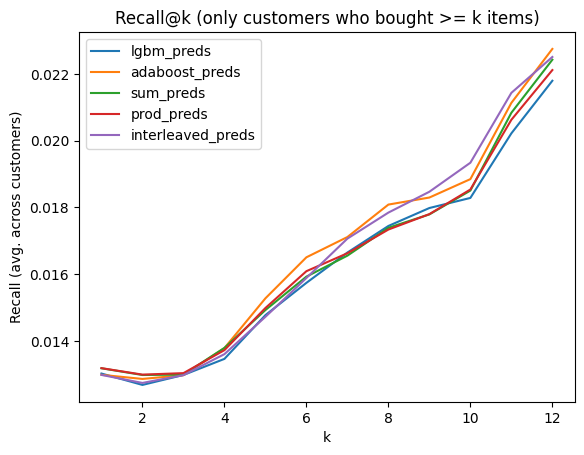

In [35]:
plt.figure()
for method, scores in pr_curves_dense.items():
    plt.plot(range(1, len(scores[1])+1), scores[1], label=method)
plt.ylabel("Recall (avg. across customers)")
plt.xlabel("k")
plt.title(f"Recall@k (only customers who bought >= k items)")
plt.legend()
plt.show()